In [11]:
import collections
import json


import numpy as np
import tskit
import tsinfer
import tqdm
import pandas as pd

# For the moment, install tsutil with pip install git+https://github.com/hyanwong/tsutil
import tsutil


In [2]:
# Get chr2 q arm

ts = tsutil.download(
    "https://zenodo.org/record/5495535/files/hgdp_tgp_sgdp_chr2_q.dated.trees.tsz?download=1")

hgdp_tgp_sgdp_chr2_q.dated.trees.tsz?download=1: 176MB [01:02, 2.83MB/s]                              


In [69]:
num_samples = 200  # should probably be much higher
num_sites = 2000  # should probably be much higher
fraction_inferred = 0.02
rng = np.random.default_rng(seed=123)

mismatch_params_ma = np.logspace(-5, 3, num=9)
mismatch_params_ms = np.logspace(-5, 3, num=9)
num_replicates = 5

Params = collections.namedtuple("Params", "mm_ancestors, mm_samples, replicate")
Results = collections.namedtuple("Results", "n_correct, n_tested, n_sites, n_muts")
results = {}

with tqdm.tqdm(total=len(mismatch_params_ms)*len(mismatch_params_ma)*num_replicates) as pbar:
    # NB - this could be trivially parallelised, which would speed this up substantially
    for mismatch_ancestors in mismatch_params_ma:
        for mismatch_samples in mismatch_params_ms:
            for rep in range(num_replicates):
                # NB - making a small_ts will be superceded by masking in the SGkit pipeline
                # However, using .simplify() will remove non-variable sites, which is what we want
                small_ts = ts.simplify(rng.choice(ts.samples(), size=num_samples, replace=False))
                if num_sites >= ts.num_sites:
                    raise ValueError(f"Not enough polymorphic sites left for {num_samples} samples")

                start_site = small_ts.site(rng.integers(0, small_ts.num_sites-num_sites, size=1)[0])
                stop_site = small_ts.site(start_site.id + num_sites)
                small_ts = small_ts.keep_intervals([[start_site.position, stop_site.position]]).trim()
                sd = tsinfer.SampleData.from_tree_sequence(small_ts, use_sites_time=False)
                # use a temporary mask - this should be replaced by the SGkit call mask
                total_bits = sd.num_sites * sd.num_samples
                mask_sites = np.zeros(total_bits, dtype=bool)
                missing = rng.choice(total_bits, size=int(fraction_inferred * total_bits), replace=False)
                mask_sites[missing] = True
                mask_sites = mask_sites.reshape((sd.num_sites, sd.num_samples))
                sd_copy = sd.copy()
                genos = sd_copy.sites_genotypes[:]
                genos[mask_sites] = tskit.MISSING_DATA
                sd_copy.sites_genotypes[:] = genos
                sd_copy.finalise()
                
                # Do the inference. We should probably use a recombination map here rather than a fixed rate of 1e-8
                # However, the huge range of mismatch ratios, from e.g. 1e-4 to 1e+4, means this shouldn't have a huge effect
                anc = tsinfer.generate_ancestors(sd_copy)
                anc_ts = tsinfer.match_ancestors(sd_copy, anc, recombination_rate=1e-8, mismatch_ratio=mismatch_ancestors)
                inferred_ts = tsinfer.match_samples(sd_copy, anc_ts, recombination_rate=1e-8, mismatch_ratio=mismatch_samples)
                num_correct = 0
                num_masked = 0
                for v_orig, v_imputed, mask in zip(sd.variants(), inferred_ts.variants(), mask_sites):
                    if np.any(mask):
                        num_masked += sum(mask)
                        num_correct += np.sum(
                            np.array(v_orig.alleles)[v_orig.genotypes[mask]] ==
                            np.array(v_imputed.alleles)[v_imputed.genotypes[mask]]
                        )
                results[Params(mismatch_ancestors, mismatch_samples, rep)] = Results(
                    n_correct=num_correct,  # Used to construct the basic fraction of imputed sites
                    n_tested=num_masked,
                    n_sites=inferred_ts.num_sites,
                    n_muts=inferred_ts.num_mutations,
                )
                pbar.update()


100%|██████████| 405/405 [2:34:40<00:00, 22.91s/it]    


In [61]:
df = pd.DataFrame(
    results.values(), 
    index=pd.MultiIndex.from_tuples(results.keys())
).reset_index()
df.columns = Params._fields + Results._fields
df

,mm_ancestors,mm_samples,replicate,n_correct,n_tested,n_sites,n_muts
0,0.00001,0.000010,0,770,800,2000,2073
1,0.00001,0.000010,1,772,800,2000,2052
2,0.00001,0.004642,0,760,800,2000,2226
3,0.00001,0.004642,1,766,800,2000,2086
4,0.00001,2.154435,0,746,800,2000,2251
5,0.00001,2.154435,1,751,800,2000,2120
6,0.00001,1000.000000,0,773,800,2000,2205
7,0.00001,1000.000000,1,759,800,2000,2272
8,0.10000,0.000010,0,749,800,2000,2247
9,0.10000,0.000010,1,758,800,2000,2225


In [62]:
means = df.groupby(list(Params._fields[:-1])).mean()
means['freq_correct'] = means.n_correct / means.n_tested
means['muts_per_site'] = means.n_muts / means.n_sites
means

replicate  n_correct  n_tested  n_sites  n_muts  \
mm_ancestors mm_samples                                                     
0.00001      0.000010           0.5      771.0     800.0   2000.0  2062.5   
             0.004642           0.5      763.0     800.0   2000.0  2156.0   
             2.154435           0.5      748.5     800.0   2000.0  2185.5   
             1000.000000        0.5      766.0     800.0   2000.0  2238.5   
0.10000      0.000010           0.5      753.5     800.0   2000.0  2236.0   
             0.004642           0.5      762.0     800.0   2000.0  2298.0   
             2.154435           0.5      762.5     800.0   2000.0  2399.5   
             1000.000000        0.5      765.5     800.0   2000.0  2349.0   
1000.00000   0.000010           0.5      762.0     800.0   2000.0  2395.0   
             0.004642           0.5      757.5     800.0   2000.0  2425.5   
             2.154435           0.5      767.5     800.0   2000.0  2330.5   
             1000.000000        0.5      755.0     800.0   2000.0  2662.0   

                          freq_correct  muts_per_site  
mm_ancestors mm_samples                                
0.00001      0.000010         0.963750        1.03125  
             0.004642         0.953750        1.07800  
             2.154435         0.935625        1.09275  
             1000.000000      0.957500        1.11925  
0.10000      0.000010         0.941875        1.11800  
             0.004642         0.952500        1.14900  
             2.154435         0.953125        1.19975  
             1000.000000      0.956875        1.17450  
1000.00000   0.000010         0.952500        1.19750  
             0.004642         0.946875        1.21275  
             2.154435         0.959375        1.16525  
             1000.000000      0.943750        1.33100

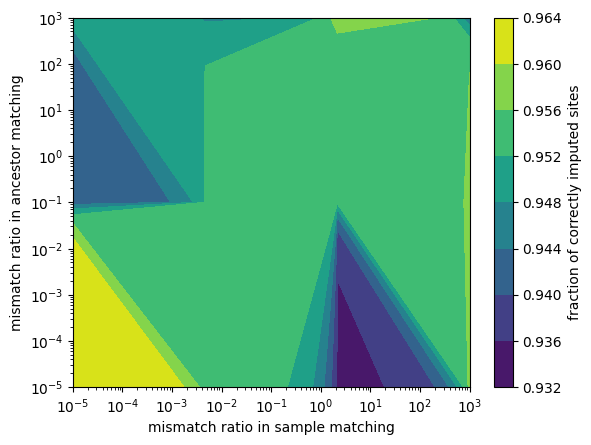

In [66]:
from matplotlib import pyplot as plt

pivot = pd.pivot_table(means, values='freq_correct', columns='mm_samples', index='mm_ancestors')
CS = plt.contourf(pivot.columns.values, pivot.index.values, pivot.values)
plt.xscale('log')
plt.xlabel('mismatch ratio in sample matching')
plt.yscale('log')
plt.ylabel('mismatch ratio in ancestor matching')
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('fraction of correctly imputed sites')
plt.show()

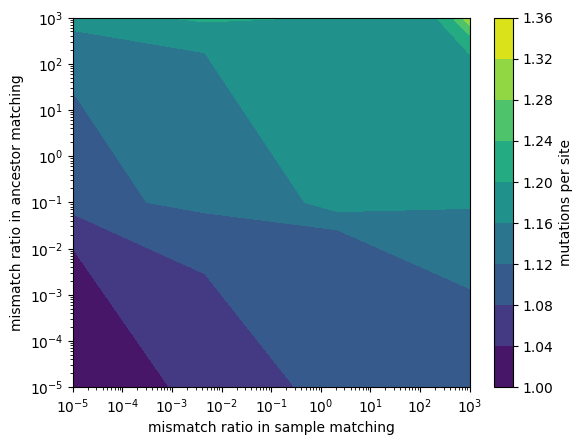

In [68]:
from matplotlib import pyplot as plt

pivot = pd.pivot_table(means, values='muts_per_site', columns='mm_samples', index='mm_ancestors')
CS = plt.contourf(pivot.columns.values, pivot.index.values, pivot.values)
plt.xscale('log')
plt.xlabel('mismatch ratio in sample matching')
plt.yscale('log')
plt.ylabel('mismatch ratio in ancestor matching')
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('mutations per site')
plt.show()